# Network Analysis

In this section, we delve into the relationship between celebrity actors and movie ratings. We perform network analysis to evaluate the impact, if any, of different cast combinations on average movie ratings. 
We represent work collaborations among actors with a network graph, where actors are nodes and every edge between two actors indicates a connection them, meaning that they have co-starred in the same movie. 

In [205]:
# Import all libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image, ImageDraw
import networkx as nx
import community

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [206]:
# Open the cleaned datasets from the cleaned_datasets folder
movies = pd.read_csv('cleaned_datasets/movies_clean.csv') 
characters = pd.read_csv('cleaned_datasets/characters_clean.csv')
actors_info = pd.read_csv('cleaned_datasets/actors_info_clean.csv')

We check the datasets to ensure that the column entries that we necessitate for the analysis do not have NaN entries. Specifically, for the movies dataset we look at `wikipedia_id`, `freebase_id`, `averageRating`; for actors_info we look at `freebase_actor_id` and `movies`; for the characters dataset we look at `freebase_actor_id` and `freebase_movie_id`. 

In [207]:
movies.isna().sum()

wikipedia_id                   0
freebase_id                    0
name                           0
release_date                   0
revenue                    21460
runtime                        0
languages                      0
countries                      0
genres                         0
year_release                   0
averageRating                  0
numVotes                       0
average_award_cumcount      3702
average_movies_cumcount     3702
award_cumcount              3702
movies_cumcount             3702
dtype: int64

In [209]:
actors_info.isna().sum()

actor_birth           76097
actor_gender          37800
actor_height         121294
actor_etnicity       125974
actor_name                1
freebase_actor_id         1
awards                    0
movies                    1
Fame                      0
Liked                     0
Disliked                  0
Neutral                   0
dtype: int64

In [211]:
characters.isna().sum()

wikipedia_movie_id                 0
freebase_movie_id                  0
movie_release_date                 0
character_name                 90614
actor_birth                    37774
actor_gender                   16299
actor_height                  107893
actor_etnicity                134592
actor_name                       149
actor_age_at_release           56626
freebase_char_actor_map_id         0
freebase_character_id          90610
freebase_actor_id                  0
Fame                               0
Liked                              0
Disliked                           0
Neutral                            0
award_cumcount                     0
movies_cumcount                    0
dtype: int64

We establish that the movies and characters datasets do have NaN values for the columns specified above, whereas 1 actor in the actors_info dataset has missing name, id and movie information; we remove the entry.

In [213]:
# Removing actors without movie information
actors_info = actors_info[actors_info['movies'].notna()]

In order to filter out outdated data, we solely consider movies released in the 21st century. We then merge the movie dataset with the characters dataset to obtain the `freebase_actor_id` of the actors who played in the respective movies. 

In [214]:
# Removing movies from before 2000
movies = movies[movies['year_release'] >= 2000] 

# Rename movies' column 
movies = movies.rename(columns={'freebase_id': 'freebase_movie_id'}) 

# Merging movies with characters on freebase_movie_id
# to get the actors' freebase_actor_id
movies_characters = pd.merge(
    left=movies,
    right=characters,
    left_on="freebase_movie_id",  # Column from the "movies" DataFrame
    right_on="freebase_movie_id"  # Column from the "characters" DataFrame
)

# Filter out duplicates of 'freebase_movie_id' and 'freebase_actor_id'
movies_characters = movies_characters.drop_duplicates(
    subset=["freebase_movie_id", "freebase_actor_id"], keep="first"
)

### One Hot Encoding of Actors

In network analysis, one-hot encoding is often used to convert categorical variables, such as the actors' unique identifier `freebase_actor_id`, into a binary vector representation that can be easily understood by machine learning algorithms. If an actor has a particular freebase_actor_id, the corresponding variable will be set to 1, and all other variables will be set to 0.

One-hot encoding is particularly useful in network analysis because it allows us to capture the relationships between movies and the actors who have worked in them based on their freebase_actor_id. For example, for a movie represented by its unique identifier `wikipedia_id`, if two actors have played in, they will have a value of 1 in the corresponding `freebase_actor_id` variable, indicating that they are connected in some way. This information can be used to analyze the network structure and relationships between actors in the network.

In [215]:
# One Hot Encoding of Actors
actor_one_hot = pd.get_dummies(
    data=movies_characters, columns=["freebase_actor_id"]
)

# Only include wikipedia_id and one hot encoding of actors in dataframe
actor_one_hot = actor_one_hot.filter(
    regex="wikipedia_id|freebase_actor_id_"
)

actor_one_hot.shape

(61752, 35973)

Since there exist over 60'000 movie entries in our current dataframe, we decide to set different thresholds of the number of movies that an actor has played in and to explore how many actors meet that threshold. 
We choose 5, 10, 12 and 15 as threshold values and display a logarithmic plot distibution of the results. 

Number of actors with more than 5 movie appearances: 1581
Number of actors with more than 10 movie appearances: 330
Number of actors with more than 12 movie appearances: 178
Number of actors with more than 15 movie appearances: 50


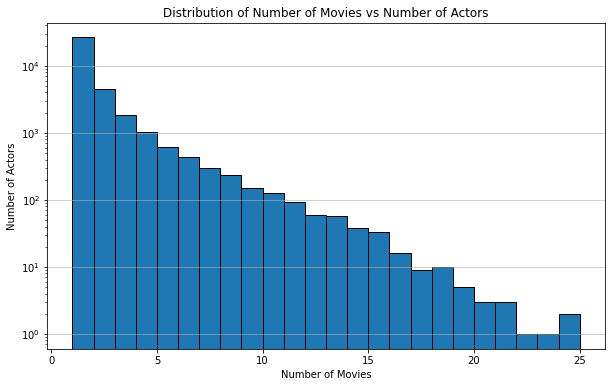

In [216]:
# Create subsets of actor one-hot encoding for different movie count thresholds
actor_one_hot_5 = actor_one_hot.loc[:, actor_one_hot.sum(axis=0) > 5]
actor_one_hot_10 = actor_one_hot.loc[:, actor_one_hot.sum(axis=0) > 10]
actor_one_hot_12 = actor_one_hot.loc[:, actor_one_hot.sum(axis=0) > 12]
actor_one_hot_15 = actor_one_hot.loc[:, actor_one_hot.sum(axis=0) > 15]

# Print the number of actors that have played in more than x movies
print("Number of actors with more than 5 movie appearances: {}".format(actor_one_hot_5.shape[1] - 1))
print("Number of actors with more than 10 movie appearances: {}".format(actor_one_hot_10.shape[1] - 1))
print("Number of actors with more than 12 movie appearances: {}".format(actor_one_hot_12.shape[1] - 1))
print("Number of actors with more than 15 movie appearances: {}".format(actor_one_hot_15.shape[1] - 1))

# Calculate the count of actors for each number of movie appearances
actors_per_movie_count = actor_one_hot.sum(axis=0)

# Remove the count of the "wikipedia_id" column
actors_per_movie_count = actors_per_movie_count.drop("wikipedia_id")

# Create a histrogram with logarithmic scale on the y-axis
plt.figure(figsize=(10, 6))
plt.hist(actors_per_movie_count, bins=range(1, actors_per_movie_count.max() + 1), edgecolor='k')
plt.xlabel('Number of Movies')
plt.ylabel('Number of Actors')
plt.title('Distribution of Number of Movies vs Number of Actors')
plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
plt.show()


We decide to restrict our dataframe to actors who worked in more than 12 movies since it represents the midpoint of the number of movies that actors have played in (from 1 to 25). 

In [217]:
actor_one_hot_choice = actor_one_hot_12

We merge the actor_one_hot_choice dataframe with the movies dataframe in order to have direct access to each movie's information and the one-hot encoded actors who played in it. 

In [218]:
# Grouping movies so that each movie corresponds to a single row in the dataframe
movies_grouped_by_actor = actor_one_hot_choice.groupby("wikipedia_id").agg("sum")

# Merging the dummy actor columns with the movie data
movies_actors_one_hot = pd.merge(
    movies, movies_grouped_by_actor, left_on="wikipedia_id", right_index=True
)

# Check the shape of the resulting dataframe
movies_actors_one_hot.shape

(6434, 66)

We generate a graph with acotrs as nodes and connections as edges indicating that the two actors have worked together on a movie. Specifically, the thickness of the edge-connections is proportional to the number of movie collaborations of the respective actor pairs, and the size of the actor-nodes is proportional to the average rating of the movies that the corresponding actor has been in.

In [273]:
# Create an empty graph
G = nx.Graph()

# Initialize dictionaries to store actor ratings and movies
actor_ratings = {}  # Dictionary to store total ratings and movie count for each actor
actor_movies = {}   # Dictionary to store the movies each actor has appeared in

# Iterate over the rows in the movies_actors_one_hot dataframe
for _, row in movies_actors_one_hot.iterrows():
    # Get the movie's rating
    rating = row['averageRating']

    # Get the actors in this movie
    actors = [actor for actor in row.index if actor.startswith('freebase_actor_id') and row[actor] == 1]
    
    for actor in actors:
        if actor not in actor_ratings:
            actor_ratings[actor] = [rating, 1]  # Store total ratings and movie count for each actor
            G.add_node(actor, size=rating)  # Add actor as a node to the graph with size equal to rating
            actor_movies[actor] = [row['freebase_movie_id']]  # Store the movie that this actor has appeared in
        else: 
            actor_ratings[actor][0] += rating  # Update total ratings for this actor
            actor_ratings[actor][1] += 1  # Update movie count for this actor
            G.nodes[actor]['size'] = actor_ratings[actor][0] / actor_ratings[actor][1]  # Update node size
            actor_movies[actor].append(row['freebase_movie_id'])  # Add this movie to the list of movies for this actor
    
    # Add edges between actors that have played in the same movie
    for i in range(len(actors)):
        for j in range(i+1, len(actors)):
            actor1 = actors[i]
            actor2 = actors[j]
            if G.has_edge(actor1, actor2):
                G[actor1][actor2]['weight'] += 1  # Update the weight of the existing edge
            else:
                G.add_edge(actor1, actor2, weight=1)  # Add a new edge with weight 1  

# Update the weight of each edge to be the number of movies that the actors have played in together
for actor1, actor2 in G.edges():
    movies1 = actor_movies[actor1]
    movies2 = actor_movies[actor2]
    weight = len(set(movies1).intersection(movies2))  # Number of movies that both actors have appeared in
    G[actor1][actor2]['weight'] = weight

In [220]:
# Get the number of edges
num_nodes = G.number_of_nodes()
print("The number of nodes in the graph G is:", num_nodes)

# Get the number of edges
num_edges = G.number_of_edges()
print("The number of edges in the graph G is:", num_edges)

The number of nodes in the graph G is: 50
The number of edges in the graph G is: 178


This results in a graph of 50 actor-nodes and 178 edge-connections, displayed below with actor names as node labels, edge-thickness proportional to the number of movie collaborations of the respective actor pairs, and size of the actor-nodes proportional to the average rating of the movies that the corresponding actor has been in.

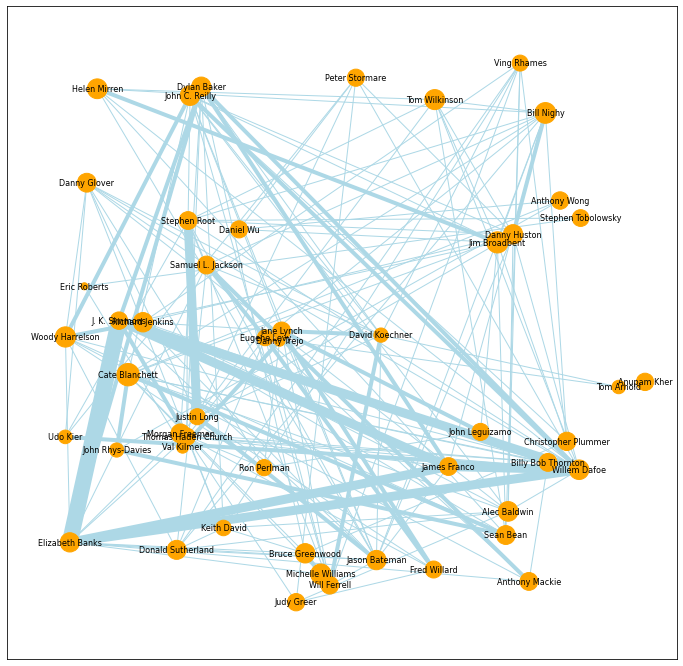

In [288]:
# Create a figure
plt.figure(figsize=(12,12))

# Get the node sizes
node_sizes = nx.get_node_attributes(G, 'size')

# Get the edge weights
edge_weights = nx.get_edge_attributes(G, 'weight')  

# Get the actor names from the characters dataframe
actor_names = characters.set_index('freebase_actor_id')['actor_name'].to_dict()

# Match the actor names to the node IDs
actor_names = {node: actor_names[node.split('_id_')[1]] for node in node_sizes}

# Position the nodes randomly
pos = nx.random_layout(G)

# Rescale the edge weights s.t. the smallest edge is 50 and the largest is 500
node_sizes = {node: node_sizes[node] for node in node_sizes}
node_sizes = {node: (node_sizes[node] - min(node_sizes.values())) / (max(node_sizes.values()) - min(node_sizes.values())) for node in node_sizes}
node_sizes = {node: 50 + 450 * node_sizes[node] for node in node_sizes}

# Draw the nodes with labels
nx.draw_networkx_nodes(G, pos=pos, node_size=[node_sizes[v] for v in G.nodes()], node_color='orange')

# Draw the edges
nx.draw_networkx_edges(G, pos=pos, edge_color='lightblue', width=[w**2 for _, _, w in G.edges(data='weight')])

# Draw the node labels
nx.draw_networkx_labels(G, pos=pos, labels=actor_names, font_size=8)

# Save the plot
plt.savefig('img/actor_network_num_movies.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


We explore the presence of communities among actors in order to gain valuable insights into the relationships and interactions between actors within a movie network. Communities refer to groups of actors who have a higher likelihood of collaborating with each other in movies. By identifying these communities, we can gain a better understanding of the social structure within the movie industry and how it influences various aspects of movie production, in particular whether certain groups of actors consistently work together in movies that receive higher or lower ratings. This information can be useful in determining the impact of actor collaborations on the overall quality of movies. For example, if a particular community consistently produces highly-rated movies, it may indicate that the actors within that community have a strong synergy or shared expertise.

The Girvan-Newman algorithm is a community detection algorithm that iteratively removes edges with the highest betweenness centrality. It is generally a more fine-grained algorithm with higher computational complexity than the Louvain method explained below. 

In [224]:
# Perform community partitioning using Girvan-Newman method
communities = list(nx.community.girvan_newman(G))

# Get the number of communities
num_communities = len(communities)

# Print the number of communities
print("The number of communities detected using Girvan-Newman method is:", num_communities)

The number of communities detected using Girvan-Newman method is: 48


The Louvain method is a popular algorithm for community detection in network analysis that works as a two-step iterative process. In the first step, each node is assigned to its own community, while in the second step, the algorithm optimizes the modularity of the network by iteratively merging communities. The Louvain method is known for its efficiency and ability to handle large-scale networks. 

In [225]:
# Detect communities in the graph through the Louvain method 
partition = community.best_partition(G, random_state=1, weight='weight') 

communities = {}

# Partition actors in communities
for actor, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = [actor]
    else:
        communities[community_id].append(actor)
        
# Get the number of communities
num_communities = len(communities)
        
print("The number of communities detected using Louvian method is:", num_communities)

The number of communities detected using Louvian method is: 7


Since the Girvan-Newman method results in too many communities (nearly as many as the actors) with a single actor per community, we choose to base our following analyses on the communities detected by the Louvian method.

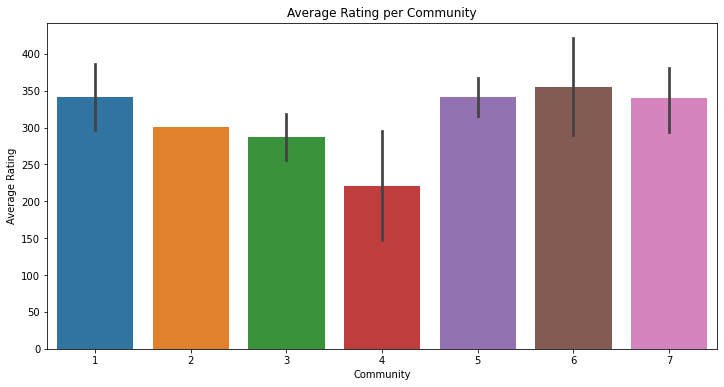

In [285]:
# Create a figure
plt.figure(figsize=(12,6))

# Create a Pandas dataframe from the dictionary
actors = pd.DataFrame.from_dict(partition.items(), orient='columns')

actors.columns = ['actor', 'community']

actors['averageRating'] = actors['actor'].apply(lambda x: node_sizes[x])

ax = sns.barplot(x="community", y="averageRating", data=actors)

plt.xlabel('Community')
plt.ylabel('Average Rating')
plt.title('Average Rating per Community')
plt.xticks([x for x in range(7)], [x for x in range(1, 8)])

# Save the plot in the img folder
plt.savefig('img/community_rating_num_movies.png', dpi=300, bbox_inches='tight')
plt.show()

We conduct ANOVA (Analysis of Variance) to analyze the average ratings of different communities. The goal is to determine if there is a statistically significant difference in the average ratings across these communities.
This ANOVA analysis helps us understand the relationship between the communities and the average ratings, providing valuable insights for further analysis or decision-making.

In [228]:
# ANOVA

# Create a list of average ratings for each community
community_ratings = [actors.loc[actors['community'] == i, 'averageRating'] for i in range(7)]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*community_ratings)

# Output the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Interpret the results based on the p-value
if p_value < 0.05:
    print("The difference in average rating across communities is statistically significant.")
else:
    print("There is no statistically significant difference in average rating across communities.")

F-statistic: 2.718249193040265
p-value: 0.025052313464406856
The difference in average rating across communities is statistically significant.


## Network Graph: Age Gap among Actors or Not ?

In [229]:
# Filter the characters dataframe to only include the actors that are also found in the movies_actors_one_hot dataframe

# Get the column names from the movies_actors_one_hot dataframe
column_names = movies_actors_one_hot.columns

# Prepend 'freebase_actor_id_' to each value in the 'freebase_actor_id' column
modified_ids = 'freebase_actor_id_' + characters['freebase_actor_id'].astype(str)

# Filter the dataframe using the modified IDs
actors_in_movies = characters[modified_ids.isin(column_names)]

# Remove the actors that do not have an actor_age_at_release value in the characters dataframe
actors_in_movies = actors_in_movies[actors_in_movies['actor_age_at_release'].notna()]

# Filter the movies_actors_one_hot dataframe to only include the actors that have an actor_age_at_release value
movies_actors_one_hot_age = movies_actors_one_hot[movies_actors_one_hot['wikipedia_id'].isin(actors_in_movies['wikipedia_movie_id'])]

movies_actors_one_hot_age.shape

(725, 66)

In [246]:
# Create a new graph for actor connections based on age difference
G_age = nx.Graph()

# Initialize dictionaries to store actor ratings and movie information
actor_ratings_age = {}  # Dictionary to store total ratings and movie count for each actor
actor_movies_age = {}   # Dictionary to store the movies that each actor has appeared in

# Iterate over the rows in the movies_actors_one_hot_age dataframe
for _, row in movies_actors_one_hot_age.iterrows():
    # Get the movie's rating
    rating = row['averageRating']

    # Get the actors in this movie
    actors = [actor for actor in row.index if actor.startswith('freebase_actor_id') and row[actor] == 1]
    
    for actor in actors:
        if actor not in actor_ratings_age:
            actor_ratings_age[actor] = [rating, 1]  # Store total ratings and movie count for each actor
            G_age.add_node(actor, size=rating)  # Add actor as a node to the graph with size equal to rating
            actor_movies_age[actor] = [row['freebase_movie_id']]  # Store the movie that this actor has appeared in
        else: 
            actor_ratings_age[actor][0] += rating  # Update total ratings for this actor
            actor_ratings_age[actor][1] += 1  # Update movie count for this actor
            G_age.nodes[actor]['size'] = actor_ratings_age[actor][0] / actor_ratings_age[actor][1]  # Update node size
            actor_movies_age[actor].append(row['freebase_movie_id'])  # Add this movie to the list of movies for this actor
    
    # Create edges between actors who have appeared in the same movie
    for i in range(len(actors)):
        for j in range(i+1, len(actors)):
            actor1 = actors[i]
            actor2 = actors[j]
            
            # Create modified actor IDs for comparison
            modified_ids = 'freebase_actor_id_' + actors_in_movies['freebase_actor_id'].astype(str)
            
            # Retrieve age of actor1 and actor2 in the current movie
            age_actor1 = actors_in_movies[(modified_ids == actor1) & (actors_in_movies['freebase_movie_id'] == row['freebase_movie_id'])]['actor_age_at_release'].iloc[0]
            age_actor2 = actors_in_movies[(modified_ids == actor2) & (actors_in_movies['freebase_movie_id'] == row['freebase_movie_id'])]['actor_age_at_release'].iloc[0]

            # Ensure the ages are floats
            age_actor1 = float(age_actor1)
            age_actor2 = float(age_actor2)

            # Calculate age difference
            age_diff = abs(age_actor1 - age_actor2)
            if age_diff == 0.0:
                age_diff = 1.0
            
            # Rescale age difference to be between 1 and 2 
            age_diff = (1 / age_diff) + 1

            if not G_age.has_edge(actor1, actor2):
                # Add a new edge with weight equal to age difference
                G_age.add_edge(actor1, actor2, weight=age_diff)


In [247]:
# Get the number of edges
num_nodes_age = G_age.number_of_nodes()
# Print the number of edges
print("The number of nodes in the graph G is:", num_nodes_age)

# Get the number of edges
num_nodes_age = G_age.number_of_edges()
# Print the number of edges
print("The number of edges in the graph G is:", num_nodes_age)

The number of nodes in the graph G is: 50
The number of edges in the graph G is: 176


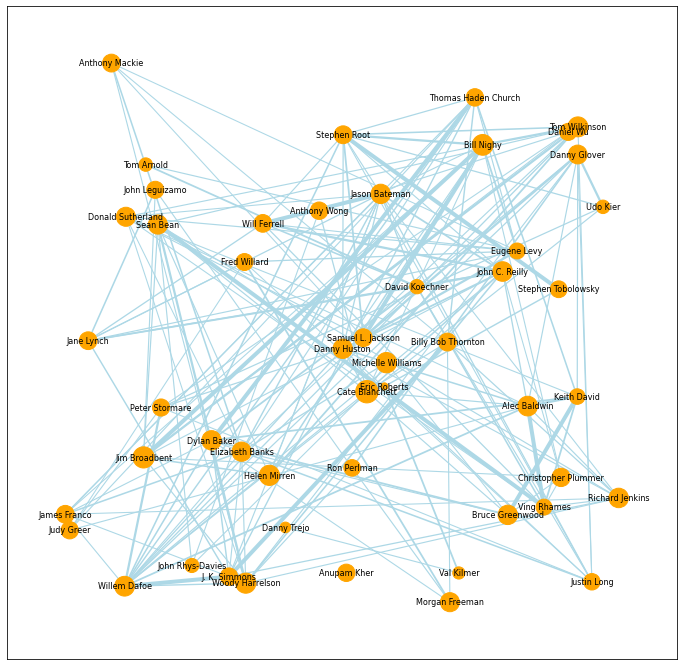

In [287]:
# Create a figure
plt.figure(figsize=(12,12))

# Get the node sizes
node_sizes = nx.get_node_attributes(G_age, 'size')

# Get the edge weights
edge_weights = nx.get_edge_attributes(G_age, 'weight')  

# Get the actor names from the characters dataframe
actor_names = characters.set_index('freebase_actor_id')['actor_name'].to_dict()

# Match the actor names to the node IDs
actor_names = {node: actor_names[node.split('_id_')[1]] for node in node_sizes}

# Position the nodes randomly
pos = nx.random_layout(G_age)

# Rescale the edge weights s.t. the smallest edge is 50 and the largest is 500
node_sizes = {node: node_sizes[node] for node in node_sizes}
node_sizes = {node: (node_sizes[node] - min(node_sizes.values())) / (max(node_sizes.values()) - min(node_sizes.values())) for node in node_sizes}
node_sizes = {node: 50 + 450 * node_sizes[node] for node in node_sizes}

# Draw the nodes with labels
nx.draw_networkx_nodes(G_age, pos=pos, node_size=[node_sizes[v] for v in G_age.nodes()], node_color='orange')

# Draw the edges
nx.draw_networkx_edges(G_age, pos=pos, edge_color='lightblue', width=[w**2 for _, _, w in G_age.edges(data='weight')])

# Draw the node labels
nx.draw_networkx_labels(G_age, pos=pos, labels=actor_names, font_size=8)

# Save the plot
plt.savefig('img/actor_network_age.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [249]:
# Use the Louvain method to detect communities in the graph
partition_age = community.best_partition(G_age, random_state=1, weight='weight')

communities_age = {}

# Print the actors in each community
for actor, community_id in partition_age.items():
    if community_id not in communities_age:
        communities_age[community_id] = [actor]
    else:
        communities_age[community_id].append(actor)
        
print(len(communities_age))


8


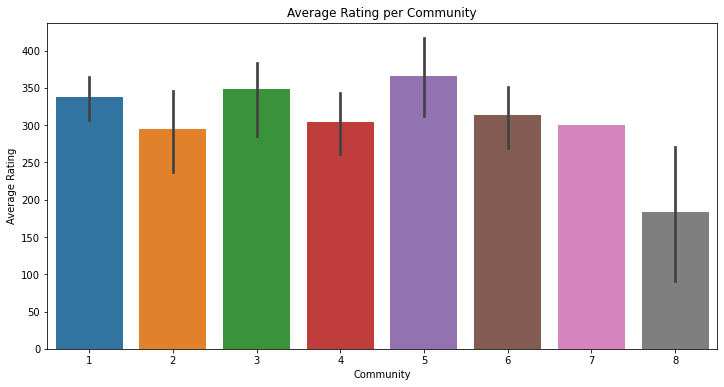

In [286]:
# Create a figure
plt.figure(figsize=(12,6))

# Create a Pandas dataframe from the dictionary
actors = pd.DataFrame.from_dict(partition_age.items(), orient='columns')

actors.columns = ['actor', 'community']

actors['averageRating'] = actors['actor'].apply(lambda x: node_sizes[x])

ax = sns.barplot(x="community", y="averageRating", data=actors)

plt.xlabel('Community')
plt.ylabel('Average Rating')
plt.title('Average Rating per Community')
plt.xticks([x for x in range(8)], [x for x in range(1, 9)])

plt.savefig('img/community_rating_age.png', dpi=300, bbox_inches='tight')
plt.show()

In [251]:
# ANOVA

# Create a list of average ratings for each community
community_ratings = [actors.loc[actors['community'] == i, 'averageRating'] for i in range(8)]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*community_ratings)

# Output the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Interpret the results based on the p-value
if p_value < 0.05:
    print("The difference in average rating across communities is statistically significant.")
else:
    print("There is no statistically significant difference in average rating across communities.")

F-statistic: 3.3041819137456327
p-value: 0.00685196497710805
The difference in average rating across communities is statistically significant.
